https://towardsdatascience.com/predict-the-number-of-likes-on-instagram-a7ec5c020203

# Imports

In [16]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

from lib.utils import clean_sentence, clean_text
from lib.preprocess_utils import 

In [45]:
import pandas as pd
import json
import numpy as np
import re
import pickle
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [6]:
DATA_PATH = '../data_like/'

In [10]:
train = pd.read_csv(DATA_PATH+'customer_train.csv')
test = pd.read_csv(DATA_PATH+'customer_test.csv')

stories = pd.read_csv(DATA_PATH+'stories_description.csv')

train_y = pd.read_csv(DATA_PATH+'stories_reaction_train.csv')
test_y = pd.read_csv(DATA_PATH+'stories_reaction_test.csv')

transaction = pd.read_csv(DATA_PATH+'transactions.csv')

In [12]:
description = pd.read_excel(DATA_PATH+'Hack_desc.xlsx')
description.index = description['customer']
description = description.drop(labels=['customer'], axis=1)

In [13]:
description['Unnamed: 1'].loc['event']

'Тип действия. like - лайк или сохранение. view - глубокий просмотр (более 10 секунд). skip - пролистанная история (менее 5 секунд). dislike - дизлайк'

# Extracting text features from jsons

### !!!!Тема сториза!!!!1

In [14]:
REG_TEXT = "text\":\"(.*?)\","
REG_NAME = "name\":\"(.*?)\","

r = re.findall(REG_NAME, stories['story_json'][10])

In [17]:
decoded_stories = dict()
for i in stories.index:
    cur_story = stories['story_json'][i]
    story_info = dict()
    name = re.findall(REG_NAME, cur_story)
    story_info['name'] = "" if len(name) == 0 else clean_sentence(name[0])
    story_info['text'], story_info['swipes'], story_info['n_words'] = clean_text(re.findall(REG_TEXT, cur_story))
    decoded_stories[stories['story_id'][i]] = story_info

In [32]:
# with open("stories", "wb") as fp:
#     pickle.dump(decoded_stories, fp)

In [33]:
# with open("stories", "rb") as fp:
#     b = pickle.load(fp)

# Data Analysis 

## 1) Likes, Dislikes and other stuff

In [18]:
len(list(set(train_y.customer_id).intersection(set(test_y.customer_id))))

14260

In [19]:
len(list(set(train_y.story_id).intersection(set(test_y.story_id))))

670

#### Some customers from train are also in test as well as stories

In [21]:
inter = list(set(train_y.customer_id).intersection(set(test_y.customer_id)))
num = 4

In [22]:
train_y[train_y.customer_id==inter[num]]

,customer_id,story_id,event_dttm,event
444336,917520,129,2018-05-31 05:05:34,view
444337,917520,129,2018-06-01 13:14:11,view
444338,917520,133,2018-05-28 11:58:47,skip
444339,917520,136,2018-05-28 11:58:47,view
444340,917520,138,2018-06-20 15:50:13,skip
444341,917520,171,2018-05-24 04:45:37,view
444342,917520,202,2018-06-14 01:43:54,view
444343,917520,202,2018-06-14 14:50:16,skip
444344,917520,202,2018-06-15 14:01:51,skip
444345,917520,216,2018-06-27 06:21:37,view


#### Customers can watch the same stories few times, can be a good feature

In [24]:
train_y.event.value_counts() / len(train_y)

view       0.512135
skip       0.354159
like       0.119810
dislike    0.013896
Name: event, dtype: float64

top_liked : top_disliked  ==  31 <br>
top_viewed : top_disliked  ==  22 <br>
top_skiped : top_disliked  ==  20 <br>
top_viewed : top_liked  == 29 <br>
top_skiped : top_liked == 24 <br>
top_viewed : top_skiped == 27 <br>

### ???? disliked are much more similar to liked, may be it is a misclick of user ?????

## 2) Users info

In [28]:
common_n_status = set(train['marital_status_cd'].value_counts().keys()[train['marital_status_cd'].value_counts() > 2])
train.marital_status_cd = [ch if ch in common_n_status else nan for ch in train.marital_status_cd]

#### Let's watch by eyes to data

In [29]:
# categorial_feat = ['product_0', 'product_1', 'product_2', 'product_3', 
#                    'product_4', 'product_5', 'product_6', 'gender_cd',
#                    'marital_status_cd', 'children_cnt', 'job_position_cd', 'job_title']
# for col in categorial_feat:
#     print('FEATURE:', col)
#     print(train[col].value_counts())
#     print('Nans:', len(train) - np.sum(train[col].value_counts()))
#     print('_________')

#### Let's see data of registration

In [38]:
years = []
for i in range(len(train)):
    if isinstance(train.first_session_dttm[i], str):
        years.append(datetime.strptime(train.first_session_dttm[i], '%Y-%m-%d %H:%M:%S').year)
    else:
        years.append('NaN')
np.unique(years)

array(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       'NaN'], dtype='<U21')

#### Let's see age

In [32]:
train.age = train.age.fillna(0)
np.unique(train.age)

array([ 0., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60., 65., 70.,
       75., 80., 85.])

### can use it as a categorial feature

## 3) Transactions

In [33]:
description.loc[transaction.columns].iloc[3: ]

,Unnamed: 1
customer,
customer_id,Идентификатор клиента
transaction_month,Месяц транзакции
transaction_day,День транзакции
transaction_amt,Сумма транзакции в рублях
merchant_id,"Идентификатор магазина, в котором была соверше..."
merchant_mcc,MCC-категория магазина


#### There are a lot of popular shops, maybe like x5 

In [34]:
len(transaction.merchant_mcc.value_counts())

409

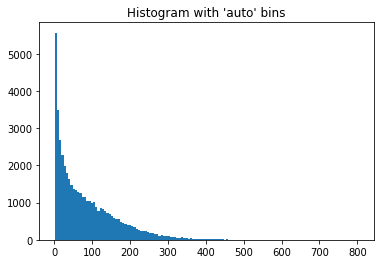

514522     804
588639     788
333041     768
588106     700
673392     690
878241     674
533341     666
67304      653
334074     634
110621     623
141608     621
177704     608
335239     602
744399     598
540513     596
43361      588
598655     578
141084     564
634747     562
192793     559
130931     559
87429      557
249174     552
49203      546
301112     540
153166     539
135465     539
835803     536
8481       536
456478     534
          ... 
34462        1
775470       1
667131       1
675777       1
969138       1
342357       1
695788       1
884801       1
668720       1
540920       1
439181       1
741349       1
133167       1
828986       1
974677       1
126204       1
559694       1
727308       1
784656       1
957106       1
185147       1
462450       1
488335       1
570468       1
739851       1
542958       1
462666       1
743422       1
1010076      1
195566       1
Name: customer_id, Length: 46948, dtype: int64

In [37]:
_ = plt.hist(transaction.customer_id.value_counts(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()
transaction.customer_id.value_counts()

#### Ideas: <br> 1. average amount of money for transaction for each user, two features: average over all transactions and of >0 rubles transactions<br> 2. average number of transaction per month <br> 3. Maybe if user visits top popular shops 

# -----------------------------

# Preprocessing

### 1) Customer_train/test

Порезаьть те вещи, которые я указал выше - done<br>
Посчитать число лет от текущего момента <br>
Переделать дату

In [50]:
train = pd.read_csv(DATA_PATH+'customer_train.csv')
test = pd.read_csv(DATA_PATH+'customer_test.csv')
print(train.shape)
print(test.shape)

(50000, 15)
(54245, 15)


In [49]:
train.head()

,customer_id,product_0,product_1,product_2,product_3,product_4,product_5,product_6,gender_cd,age,marital_status_cd,children_cnt,first_session_dttm,job_position_cd,job_title
0,894436,NaN,NaN,NaN,NaN,NaN,UTL,NaN,M,30.0,MAR,0,2018-03-20 09:10:16,1,неруководящий сотрудник - обсл. персонал
1,524526,NaN,UTL,NaN,NaN,NaN,UTL,NaN,F,20.0,UNM,0,2017-03-29 20:38:45,16,NAN
2,498134,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,25.0,UNM,0,2018-03-12 11:25:06,22,NAN
3,278941,NaN,NaN,UTL,CLS,NaN,UTL,UTL,M,25.0,NAN,NAN,2016-02-21 18:47:51,16,неруководящий сотрудник - специалист
4,877312,NaN,UTL,NaN,NaN,NaN,NaN,NaN,F,40.0,MAR,0,2018-03-07 11:17:02,22,NAN


#### Cutting very rare stuff

In [53]:
nan = 'NAN'
train = train.fillna(nan)

In [55]:
# Delete rare jobs because it may be useless during one-hot encoding
train.job_title = [job.lower() if isinstance(job, str) else job for job in train.job_title]
common_jobs = set(train['job_title'].value_counts().keys()[train['job_title'].value_counts() > 50])
train.job_title = [job if job in common_jobs else nan for job in train.job_title]

In [62]:
common_n_status = set(train['marital_status_cd'].value_counts().keys()[train['marital_status_cd'].value_counts() > 2])
train.marital_status_cd = [ch if ch in common_n_status else nan for ch in train.marital_status_cd]

#### Calculating amount of time since regestration till now

In [73]:
(datetime.today() - datetime.strptime(train.first_session_dttm[i], '%Y-%m-%d %H:%M:%S')).days / 365

2.164383561643836

In [87]:
def calc_duration(data):
    new_col = [0] * len(data)
    for i in range(len(data)):
        date = data.first_session_dttm[i]
        if date != 'NAN':
            duration = (datetime.today() - datetime.strptime(data.first_session_dttm[i], 
                                                             '%Y-%m-%d %H:%M:%S')).days / 365
            new_col[i] = duration
        
    na = np.average(new_col)
    for i in range(len(data)):
        date = data.first_session_dttm[i]
        if date == 'NAN':
            duration = na
            new_col[i] = duration
    data['duration'] = new_col

In [88]:
calc_duration(train)

#### Transform data of reg to Year of registration

#### One-Hot-Encode

In [64]:
# features_to_encode = ['product_0', 'product_1', 'product_2', 'product_3',
#                       'product_4', 'product_5', 'product_6', 'gender_cd', 'age',
#                       'marital_status_cd', 'children_cnt', 'first_session_dttm',
#                       'job_position_cd', 'job_title']
# pd.get_dummies(train, columns=['product_0', 'product_1', 'product_2', 'product_3',
#        'product_4', 'product_5', 'product_6', 'gender_cd', 'age',
#        'marital_status_cd', 'children_cnt', 'first_session_dttm',
#        'job_position_cd', 'job_title'])

In [54]:
pd.get_dummies(train[['product_0', 'product_1']])

,product_0_CLS,product_0_NAN,product_0_UTL,product_1_CLS,product_1_NAN,product_1_OPN,product_1_UTL
0,0,1,0,0,1,0,0
1,0,1,0,0,0,0,1
2,0,1,0,0,0,0,1
3,0,1,0,0,1,0,0
4,0,1,0,0,0,0,1
5,0,1,0,0,1,0,0
6,0,1,0,0,0,0,1
7,0,1,0,0,1,0,0
8,0,1,0,0,0,0,1
9,0,1,0,0,1,0,0
